# Notebook 05: Tokenization - Converting Text to Numbers

Welcome back! In the previous notebook, we built a complete GPT architecture. But we left one crucial question unanswered: **How does text become numbers that the model can process?**

This notebook is all about **tokenization** - the bridge between human language and machine learning.

## What You'll Learn

1. **Why tokenization matters** - Why we can't just use letters or words
2. **Character-level tokenization** - The simplest approach and its limitations
3. **Word-level tokenization** - The natural approach and the OOV problem
4. **Subword tokenization** - The sweet spot that modern models use
5. **Byte-Pair Encoding (BPE)** - How GPT tokenizes text (with implementation!)
6. **Special tokens** - `<BOS>`, `<EOS>`, `<PAD>`, and why they matter
7. **Vocabulary size trade-offs** - Finding the right balance

## The Big Picture

Every modern language model follows this pipeline:

```
"Hello, world!" 
      ↓ (tokenization)
[15496, 11, 995, 0]
      ↓ (embedding)
[[0.2, -0.5, ...], [0.1, 0.3, ...], ...]
      ↓ (transformer)
Output predictions
```

We built the transformer in notebook 04. Now let's understand that first step!

## A Simple Example

Here's what tokenization looks like in practice:

```python
# What you type:
text = "Hello world"

# What GPT-4 sees:
tokens = [15496, 995]  # Just two numbers!
```

By the end of this notebook, you'll understand exactly how this transformation works and why it's designed this way.

Let's dive in!

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Setup complete!")

Setup complete!


# Part 1: Why Tokenization?

## The Problem

Neural networks process numbers, not text. When you type "Hello" into ChatGPT:

- **You see**: "Hello"
- **GPT-4 sees**: `[15496]`

The question is: **How do we convert text to numbers?**

## Three Possible Approaches

Let's consider a simple sentence: **"The cat sat"**

### Option 1: Use character codes (ASCII/Unicode)
```
"The cat sat" → [84, 104, 101, 32, 99, 97, 116, 32, 115, 97, 116]
```
Problem: Just raw numbers, no semantic meaning!

### Option 2: Assign each character a token ID
```
"The cat sat" → ["T", "h", "e", " ", "c", "a", "t", " ", "s", "a", "t"]
              → [0, 1, 2, 3, 4, 5, 6, 3, 7, 5, 6]
```
Problem: Sequences get VERY long!

### Option 3: Assign each word a token ID
```
"The cat sat" → ["The", "cat", "sat"]
              → [464, 3797, 3332]
```
Problem: What about words we've never seen before?

## The Analogy: Building Blocks

Think of text like LEGO:

- **Characters** = Individual 1x1 LEGO bricks
  - Can build anything
  - But you need LOTS of them (inefficient)

- **Words** = Pre-built LEGO houses
  - Efficient for common structures
  - But can't build anything new!

- **Subwords** = Medium-sized LEGO pieces (2x4, 4x4, etc.)
  - **Just right!** Can combine to make anything
  - Efficient AND flexible

Let's implement each approach and see the trade-offs in practice!

In [2]:
# Let's visualize the different approaches

text = "The cat sat"

print("=" * 60)
print("COMPARING TOKENIZATION APPROACHES")
print("=" * 60)
print(f"\nOriginal text: '{text}'\n")

# Character-level
char_tokens = list(text)
print(f"Character-level ({len(char_tokens)} tokens):")
print(f"  Tokens: {char_tokens}")
print(f"  Vocab size needed: ~256 (all ASCII characters)")

# Word-level
word_tokens = text.split()
print(f"\nWord-level ({len(word_tokens)} tokens):")
print(f"  Tokens: {word_tokens}")
print(f"  Vocab size needed: 100,000+ (all English words)")

# Subword-level (manual example)
subword_tokens = ["The", "cat", "sat"]  # This is also word-level, but imagine:
subword_tokens_complex = ["un", "happi", "ness"]  # for "unhappiness"
print(f"\nSubword-level ({len(word_tokens)} tokens for this simple example):")
print(f"  Tokens: {word_tokens}")
print(f"  Vocab size needed: ~50,000 (balanced)")
print(f"  Example: 'unhappiness' → {subword_tokens_complex}")
print(f"  Each piece can be reused: 'un' in 'unfair', 'ness' in 'kindness'")

COMPARING TOKENIZATION APPROACHES

Original text: 'The cat sat'

Character-level (11 tokens):
  Tokens: ['T', 'h', 'e', ' ', 'c', 'a', 't', ' ', 's', 'a', 't']
  Vocab size needed: ~256 (all ASCII characters)

Word-level (3 tokens):
  Tokens: ['The', 'cat', 'sat']
  Vocab size needed: 100,000+ (all English words)

Subword-level (3 tokens for this simple example):
  Tokens: ['The', 'cat', 'sat']
  Vocab size needed: ~50,000 (balanced)
  Example: 'unhappiness' → ['un', 'happi', 'ness']
  Each piece can be reused: 'un' in 'unfair', 'ness' in 'kindness'


# Part 2: Character-Level Tokenization

Let's start with the simplest approach: **treat every character as a token**.

## The Simplest Tokenizer

In Python, this is just one line:

```python
tokens = list(text)
```

## Pros and Cons

**Pros:**
- ✅ Tiny vocabulary (26 letters + punctuation + digits ≈ 256 characters)
- ✅ Can handle ANY text (even made-up words)
- ✅ No "unknown word" problem
- ✅ Simple to implement

**Cons:**
- ❌ Sequences become VERY long
- ❌ Model has to learn that "c", "a", "t" together means cat
- ❌ Expensive: Transformer attention is O(n²) in sequence length!

## The Sequence Length Problem

```
Text: "Transformers are revolutionary"

Word-level:     4 tokens ["Transformers", "are", "revolutionary"]
Character-level: 30 tokens ["T", "r", "a", "n", "s", "f", "o", ...]
```

That's 7.5x longer! For a 1000-word essay, that's 4,000 characters vs 1,000 words.

Let's implement a character-level tokenizer from scratch:

In [3]:
class CharacterTokenizer:
    """
    Simple character-level tokenizer.
    
    Each unique character gets a unique integer ID.
    """
    
    def __init__(self):
        # Will be built from training data
        self.char_to_id = {}
        self.id_to_char = {}
        
    def build_vocab(self, text):
        """
        Build vocabulary from text.
        
        Args:
            text: String to build vocabulary from
        """
        # Get all unique characters
        unique_chars = sorted(set(text))
        
        # Assign each character an ID
        for idx, char in enumerate(unique_chars):
            self.char_to_id[char] = idx
            self.id_to_char[idx] = char
            
        print(f"Vocabulary size: {len(self.char_to_id)}")
        print(f"Characters: {list(self.char_to_id.keys())}")
        
    def encode(self, text):
        """
        Convert text to list of token IDs.
        
        Args:
            text: String to encode
            
        Returns:
            List of integer token IDs
        """
        return [self.char_to_id[char] for char in text]
    
    def decode(self, ids):
        """
        Convert list of token IDs back to text.
        
        Args:
            ids: List of integer token IDs
            
        Returns:
            Original text string
        """
        return ''.join([self.id_to_char[id] for id in ids])


# Test it out!
tokenizer = CharacterTokenizer()

# Build vocabulary
text = "Hello world! This is character-level tokenization."
tokenizer.build_vocab(text)

# Encode
encoded = tokenizer.encode("Hello")
print(f"\n'Hello' encoded: {encoded}")

# Decode
decoded = tokenizer.decode(encoded)
print(f"Decoded back: '{decoded}'")

# Show the mapping
print("\nCharacter-to-ID mapping:")
for char in "Hello":
    print(f"  '{char}' → {tokenizer.char_to_id[char]}")

Vocabulary size: 22
Characters: [' ', '!', '-', '.', 'H', 'T', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'l', 'n', 'o', 'r', 's', 't', 'v', 'w', 'z']

'Hello' encoded: [4, 9, 13, 13, 15]
Decoded back: 'Hello'

Character-to-ID mapping:
  'H' → 4
  'e' → 9
  'l' → 13
  'l' → 13
  'o' → 15


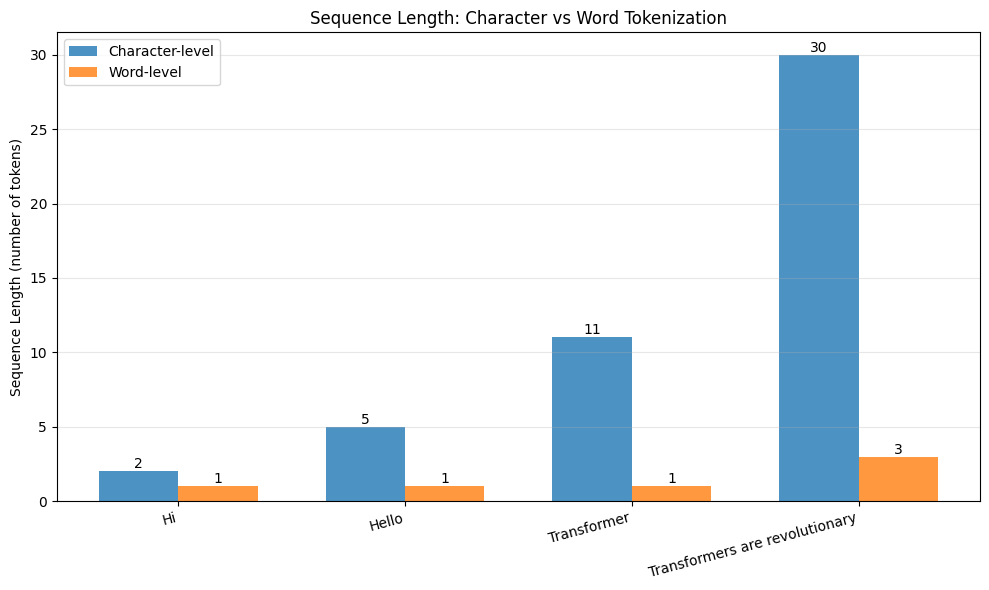


Notice: Character-level is much longer!
This means more computation for the transformer.


In [4]:
# Visualize the sequence length problem

sample_texts = [
    "Hi",
    "Hello",
    "Transformer",
    "Transformers are revolutionary"
]

char_lengths = [len(text) for text in sample_texts]
word_lengths = [len(text.split()) for text in sample_texts]

x = np.arange(len(sample_texts))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, char_lengths, width, label='Character-level', alpha=0.8)
bars2 = ax.bar(x + width/2, word_lengths, width, label='Word-level', alpha=0.8)

ax.set_ylabel('Sequence Length (number of tokens)')
ax.set_title('Sequence Length: Character vs Word Tokenization')
ax.set_xticks(x)
ax.set_xticklabels(sample_texts, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nNotice: Character-level is much longer!")
print("This means more computation for the transformer.")

## When Character-Level Makes Sense

Despite the limitations, character-level tokenization is useful for:

1. **DNA/Protein sequences** - Fixed alphabet (A, C, G, T)
2. **Music notation** - Small set of musical symbols
3. **Math expressions** - Numbers and operators
4. **Code** - When variable names are important

For natural language? We can do better!

# Part 3: Word-Level Tokenization

The most **natural** approach: split text into words!

## The Natural Approach

```python
text = "The cat sat on the mat"
tokens = text.split()  # ['The', 'cat', 'sat', 'on', 'the', 'mat']
```

## Pros and Cons

**Pros:**
- ✅ Meaningful units (words carry meaning)
- ✅ Short sequences (efficient)
- ✅ Matches human intuition

**Cons:**
- ❌ HUGE vocabulary (English has 170,000+ words)
- ❌ Unknown words are a major problem
- ❌ Related words are separate: "run", "runs", "running", "ran" all different
- ❌ Can't handle typos or rare words

## The Out-of-Vocabulary (OOV) Problem

This is the killer issue for word-level tokenization:

```
Training data: "The cat sat. The dog sat. The bird flew."
Vocabulary: {"The", "cat", "dog", "bird", "sat", "flew"}

New text: "The capybara sat"
                 ^^^^^^^^
                 Unknown word! 😱
```

What do we do with "capybara"? Common solutions:
1. Replace with `<UNK>` (unknown token) - loses information!
2. Skip it - changes the meaning!
3. Use a HUGE vocabulary - expensive and still not enough!

## The Morphology Problem

Consider these related words:

```
happy     → ID 1234
happiness → ID 5678  (completely different!)
unhappy   → ID 9012  (completely different!)
```

The model has to learn from scratch that these are related. Inefficient!

Let's implement a word-level tokenizer and see these problems in action:

In [5]:
class WordTokenizer:
    """
    Simple word-level tokenizer.
    
    Splits on whitespace and assigns each unique word an ID.
    """
    
    def __init__(self, vocab_size=None):
        """
        Args:
            vocab_size: Maximum vocabulary size (keeps most common words)
                       If None, includes all words seen during training
        """
        self.vocab_size = vocab_size
        self.word_to_id = {}
        self.id_to_word = {}
        self.unk_token = "<UNK>"  # Unknown word token
        
    def build_vocab(self, text):
        """
        Build vocabulary from text.
        
        Args:
            text: String to build vocabulary from
        """
        # Simple tokenization: split on whitespace and punctuation
        words = re.findall(r"\w+|[^\w\s]", text.lower())
        
        # Count word frequencies
        word_counts = Counter(words)
        
        # Keep most common words if vocab_size is specified
        if self.vocab_size:
            most_common = word_counts.most_common(self.vocab_size - 1)  # -1 for <UNK>
            unique_words = [word for word, count in most_common]
        else:
            unique_words = list(word_counts.keys())
        
        # Add <UNK> token first
        self.word_to_id[self.unk_token] = 0
        self.id_to_word[0] = self.unk_token
        
        # Assign IDs to words
        for idx, word in enumerate(unique_words, start=1):
            self.word_to_id[word] = idx
            self.id_to_word[idx] = word
            
        print(f"Vocabulary size: {len(self.word_to_id)}")
        print(f"Sample words: {list(unique_words[:10])}")
        
    def encode(self, text):
        """
        Convert text to list of token IDs.
        Unknown words are replaced with <UNK> token.
        
        Args:
            text: String to encode
            
        Returns:
            List of integer token IDs
        """
        words = re.findall(r"\w+|[^\w\s]", text.lower())
        
        # Replace unknown words with <UNK>
        ids = []
        for word in words:
            if word in self.word_to_id:
                ids.append(self.word_to_id[word])
            else:
                ids.append(self.word_to_id[self.unk_token])
                
        return ids
    
    def decode(self, ids):
        """
        Convert list of token IDs back to text.
        
        Args:
            ids: List of integer token IDs
            
        Returns:
            Text string
        """
        return ' '.join([self.id_to_word[id] for id in ids])


# Test it out!
tokenizer = WordTokenizer(vocab_size=10)  # Very small vocab to show OOV problem

# Build vocabulary
training_text = "The cat sat on the mat. The dog sat on the log. The bird flew."
tokenizer.build_vocab(training_text)

print("\nVocabulary:")
for word, id in sorted(tokenizer.word_to_id.items(), key=lambda x: x[1]):
    print(f"  {id}: '{word}'")

Vocabulary size: 10
Sample words: ['the', '.', 'sat', 'on', 'cat', 'mat', 'dog', 'log', 'bird']

Vocabulary:
  0: '<UNK>'
  1: 'the'
  2: '.'
  3: 'sat'
  4: 'on'
  5: 'cat'
  6: 'mat'
  7: 'dog'
  8: 'log'
  9: 'bird'


In [6]:
# Demonstrate the OOV problem

test_texts = [
    "The cat sat",           # All words in vocab
    "The dog sat",           # All words in vocab
    "The capybara sat",      # 'capybara' is OOV!
    "The unicorn galloped"   # Both 'unicorn' and 'galloped' are OOV!
]

print("=" * 60)
print("DEMONSTRATING THE OOV PROBLEM")
print("=" * 60)

for text in test_texts:
    encoded = tokenizer.encode(text)
    decoded = tokenizer.decode(encoded)
    
    print(f"\nOriginal:  '{text}'")
    print(f"Encoded:   {encoded}")
    print(f"Decoded:   '{decoded}'")
    
    if "<UNK>" in decoded:
        print(f"  ⚠️  Lost information! Unknown words replaced with <UNK>")

DEMONSTRATING THE OOV PROBLEM

Original:  'The cat sat'
Encoded:   [1, 5, 3]
Decoded:   'the cat sat'

Original:  'The dog sat'
Encoded:   [1, 7, 3]
Decoded:   'the dog sat'

Original:  'The capybara sat'
Encoded:   [1, 0, 3]
Decoded:   'the <UNK> sat'
  ⚠️  Lost information! Unknown words replaced with <UNK>

Original:  'The unicorn galloped'
Encoded:   [1, 0, 0]
Decoded:   'the <UNK> <UNK>'
  ⚠️  Lost information! Unknown words replaced with <UNK>


In [7]:
# Demonstrate the morphology problem

# Build vocab with morphologically related words
morphology_tokenizer = WordTokenizer()
morphology_text = "happy happiness unhappy run running ran runner"
morphology_tokenizer.build_vocab(morphology_text)

print("\n=" * 60)
print("THE MORPHOLOGY PROBLEM")
print("=" * 60)
print("\nRelated words get completely different IDs:")
print("\nHappy family:")
for word in ["happy", "happiness", "unhappy"]:
    print(f"  '{word}' → ID {morphology_tokenizer.word_to_id[word]}")

print("\nRun family:")
for word in ["run", "running", "ran", "runner"]:
    print(f"  '{word}' → ID {morphology_tokenizer.word_to_id[word]}")

print("\n❌ The model has to learn from scratch that these are related!")
print("   With subword tokenization, it would see:")
print("   'unhappy' → ['un', 'happy']")
print("   'running' → ['run', 'ning']")
print("   Now 'un' can be learned once and applied to any word!")

Vocabulary size: 8
Sample words: ['happy', 'happiness', 'unhappy', 'run', 'running', 'ran', 'runner']

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
THE MORPHOLOGY PROBLEM

Related words get completely different IDs:

Happy family:
  'happy' → ID 1
  'happiness' → ID 2
  'unhappy' → ID 3

Run family:
  'run' → ID 4
  'running' → ID 5
  'ran' → ID 6
  'runner' → ID 7

❌ The model has to learn from scratch that these are related!
   With subword tokenization, it would see:
   'unhappy' → ['un', 'happy']
   'running' → ['run', 'ning']
   Now 'un' can be learned once and applied to any word!


## Why Word-Level Failed for Modern LLMs

Word-level tokenization was used in early NLP systems, but it has fatal flaws:

1. **Vocabulary explosion**: English has 170,000+ words. Add other languages? Millions!
2. **OOV problem**: Can't handle new words, typos, or rare words
3. **No morphological knowledge**: Can't share learning across "run", "running", "ran"
4. **Memory cost**: Embedding matrix is `vocab_size × embedding_dim`
   - 170,000 words × 1024 dims = 174 million parameters just for embeddings!

We need something better. Enter: **subword tokenization**!

# Part 4: Subword Tokenization - The Sweet Spot

Subword tokenization is the **best of both worlds**: the flexibility of character-level with the efficiency of word-level.

## The Key Insight

Most words are made of **reusable pieces**:

```
"unhappiness" → ["un", "happi", "ness"]
```

Now these pieces can be reused:
- "un" appears in: "unfair", "undo", "unlike", "uncertain"
- "ness" appears in: "darkness", "kindness", "fitness", "sadness"
- "happi" appears in: "happiness", "happier", "happiest"

## Benefits

1. **No OOV problem**: Can always break down to characters if needed
2. **Efficient**: Sequences are much shorter than character-level
3. **Morphological knowledge**: Shares "un-" prefix across all words
4. **Reasonable vocabulary**: ~50,000 tokens instead of millions

## The Three Main Algorithms

All modern language models use subword tokenization, but different algorithms:

| Algorithm | Used By | How It Works |
|-----------|---------|-------------|
| **Byte-Pair Encoding (BPE)** | GPT-2, GPT-3, GPT-4, LLaMA | Start with characters, merge most frequent pairs |
| **WordPiece** | BERT, DistilBERT | Similar to BPE but uses likelihood scoring |
| **SentencePiece** | T5, ALBERT, XLNet | Works on raw text (no pre-tokenization) |

We'll focus on **BPE** since it's used by GPT and is conceptually the simplest.

## Comparison

Let's compare all three approaches on the same text:

In [8]:
# Compare all three approaches

text = "unhappiness"

print("=" * 60)
print(f"Tokenizing: '{text}'")
print("=" * 60)

# Character-level
char_tokens = list(text)
print(f"\nCharacter-level ({len(char_tokens)} tokens):")
print(f"  {char_tokens}")
print(f"  Vocab size: ~256")

# Word-level
word_tokens = [text]  # Whole word
print(f"\nWord-level ({len(word_tokens)} token):")
print(f"  {word_tokens}")
print(f"  Vocab size: 170,000+")
print(f"  ❌ Problem: Every related word needs separate entry")
print(f"     'unhappiness', 'happiness', 'unhappy', 'happy' all different")

# Subword-level (manual example)
subword_tokens = ["un", "happi", "ness"]
print(f"\nSubword-level ({len(subword_tokens)} tokens):")
print(f"  {subword_tokens}")
print(f"  Vocab size: ~50,000")
print(f"  ✅ Benefits:")
print(f"     'un' shared with 'unfair', 'undo', etc.")
print(f"     'ness' shared with 'kindness', 'darkness', etc.")
print(f"     'happi' shared with 'happiness', 'happier', etc.")

Tokenizing: 'unhappiness'

Character-level (11 tokens):
  ['u', 'n', 'h', 'a', 'p', 'p', 'i', 'n', 'e', 's', 's']
  Vocab size: ~256

Word-level (1 token):
  ['unhappiness']
  Vocab size: 170,000+
  ❌ Problem: Every related word needs separate entry
     'unhappiness', 'happiness', 'unhappy', 'happy' all different

Subword-level (3 tokens):
  ['un', 'happi', 'ness']
  Vocab size: ~50,000
  ✅ Benefits:
     'un' shared with 'unfair', 'undo', etc.
     'ness' shared with 'kindness', 'darkness', etc.
     'happi' shared with 'happiness', 'happier', etc.


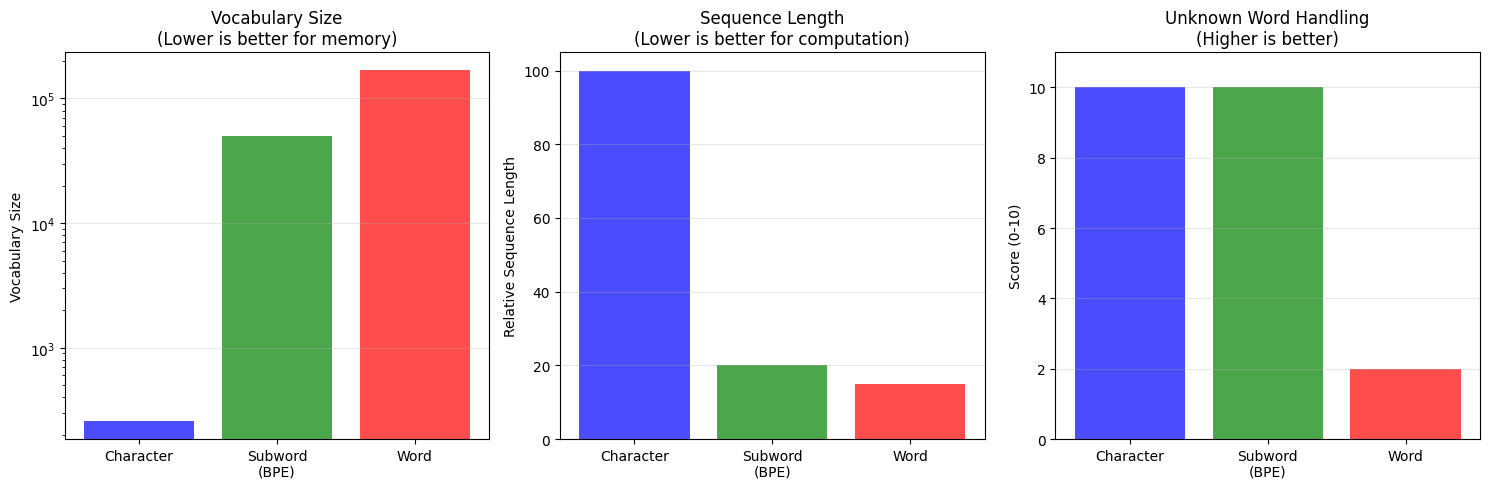


Conclusion: Subword tokenization (BPE) offers the best balance!
  ✓ Moderate vocabulary size
  ✓ Moderate sequence length
  ✓ Perfect unknown word handling


In [9]:
# Visualize the trade-offs

methods = ['Character', 'Subword\n(BPE)', 'Word']
vocab_sizes = [256, 50000, 170000]
sequence_lengths = [100, 20, 15]  # Relative for typical text
oov_handling = [10, 10, 2]  # Score out of 10

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Vocabulary size
axes[0].bar(methods, vocab_sizes, alpha=0.7, color=['blue', 'green', 'red'])
axes[0].set_ylabel('Vocabulary Size')
axes[0].set_title('Vocabulary Size\n(Lower is better for memory)')
axes[0].set_yscale('log')
axes[0].grid(axis='y', alpha=0.3)

# Sequence length
axes[1].bar(methods, sequence_lengths, alpha=0.7, color=['blue', 'green', 'red'])
axes[1].set_ylabel('Relative Sequence Length')
axes[1].set_title('Sequence Length\n(Lower is better for computation)')
axes[1].grid(axis='y', alpha=0.3)

# OOV handling
bars = axes[2].bar(methods, oov_handling, alpha=0.7, color=['blue', 'green', 'red'])
axes[2].set_ylabel('Score (0-10)')
axes[2].set_title('Unknown Word Handling\n(Higher is better)')
axes[2].set_ylim(0, 11)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConclusion: Subword tokenization (BPE) offers the best balance!")
print("  ✓ Moderate vocabulary size")
print("  ✓ Moderate sequence length")
print("  ✓ Perfect unknown word handling")

# Part 5: Byte-Pair Encoding (BPE) - Deep Dive

Now let's implement the actual algorithm used by GPT-2, GPT-3, and GPT-4!

## The Algorithm (In Plain English)

BPE is beautifully simple:

1. **Start** with character-level tokens
2. **Count** all pairs of adjacent tokens
3. **Merge** the most frequent pair into a new token
4. **Repeat** until you have the vocabulary size you want

That's it!

## Step-by-Step Example

Let's tokenize a simple corpus: `"aabdaaabac"`

**Initial state (character-level):**
```
Tokens: ['a', 'a', 'b', 'd', 'a', 'a', 'a', 'b', 'a', 'c']
```

**Iteration 1:**
```
Count pairs:
  ('a', 'a'): 3 times  ← Most frequent!
  ('a', 'b'): 2 times
  ('b', 'd'): 1 time
  ...

Merge ('a', 'a') → 'aa'

New tokens: ['aa', 'b', 'd', 'aa', 'a', 'b', 'a', 'c']
```

**Iteration 2:**
```
Count pairs:
  ('aa', 'b'): 2 times  ← Most frequent!
  ('b', 'd'): 1 time
  ...

Merge ('aa', 'b') → 'aab'

New tokens: ['aab', 'd', 'aab', 'a', 'c']
```

And so on! Let's implement this:

In [10]:
def get_pairs(tokens):
    """
    Get all adjacent pairs of tokens.
    
    Args:
        tokens: List of tokens (strings)
        
    Returns:
        Set of pairs (tuples)
    """
    pairs = set()
    
    # Look at each adjacent pair
    for i in range(len(tokens) - 1):
        pairs.add((tokens[i], tokens[i + 1]))
    
    return pairs


def count_pairs(tokens):
    """
    Count frequency of each adjacent pair.
    
    Args:
        tokens: List of tokens (strings)
        
    Returns:
        Dictionary mapping pairs to counts
    """
    pairs = defaultdict(int)
    
    # Count each adjacent pair
    for i in range(len(tokens) - 1):
        pair = (tokens[i], tokens[i + 1])
        pairs[pair] += 1
    
    return pairs


def merge_pair(tokens, pair):
    """
    Merge all occurrences of a pair in the token list.
    
    Args:
        tokens: List of tokens
        pair: Tuple of (token1, token2) to merge
        
    Returns:
        New list with pairs merged
    """
    new_tokens = []
    i = 0
    
    while i < len(tokens):
        # Check if current and next token match the pair
        if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) == pair:
            # Merge them
            new_tokens.append(tokens[i] + tokens[i + 1])
            i += 2  # Skip both tokens
        else:
            # Keep token as is
            new_tokens.append(tokens[i])
            i += 1
    
    return new_tokens


# Test the helper functions
tokens = ['a', 'a', 'b', 'd', 'a', 'a', 'a', 'b', 'a', 'c']

print("Initial tokens:", tokens)
print("\nPairs:", get_pairs(tokens))
print("\nPair counts:", dict(count_pairs(tokens)))

# Merge most frequent pair
most_frequent = max(count_pairs(tokens), key=count_pairs(tokens).get)
print(f"\nMost frequent pair: {most_frequent}")

tokens = merge_pair(tokens, most_frequent)
print(f"After merging: {tokens}")

Initial tokens: ['a', 'a', 'b', 'd', 'a', 'a', 'a', 'b', 'a', 'c']

Pairs: {('a', 'a'), ('a', 'b'), ('b', 'd'), ('d', 'a'), ('b', 'a'), ('a', 'c')}

Pair counts: {('a', 'a'): 3, ('a', 'b'): 2, ('b', 'd'): 1, ('d', 'a'): 1, ('b', 'a'): 1, ('a', 'c'): 1}

Most frequent pair: ('a', 'a')
After merging: ['aa', 'b', 'd', 'aa', 'a', 'b', 'a', 'c']


In [11]:
class BPETokenizer:
    """
    Byte-Pair Encoding tokenizer.
    
    This is a simplified version of what GPT-2/3/4 use.
    """
    
    def __init__(self, num_merges=10):
        """
        Args:
            num_merges: Number of merge operations (controls vocab size)
        """
        self.num_merges = num_merges
        self.merges = {}  # Stores merge rules: pair → merged_token
        self.vocab = set()  # All tokens in vocabulary
        
    def train(self, text):
        """
        Train BPE on a corpus.
        
        Args:
            text: Training text
        """
        # Start with character-level tokens
        # Add space marker to preserve word boundaries
        tokens = []
        for word in text.split():
            # Add </w> to mark end of word (common BPE convention)
            tokens.extend(list(word) + ['</w>'])
        
        print(f"Starting with {len(tokens)} character-level tokens")
        print(f"Initial tokens: {tokens[:20]}...\n")
        
        # Perform merges
        for i in range(self.num_merges):
            # Count all pairs
            pairs = count_pairs(tokens)
            
            if not pairs:
                break
            
            # Find most frequent pair
            best_pair = max(pairs, key=pairs.get)
            
            # Store the merge rule
            merged = best_pair[0] + best_pair[1]
            self.merges[best_pair] = merged
            
            print(f"Merge {i+1}: {best_pair} → '{merged}' (count: {pairs[best_pair]})")
            
            # Apply merge
            tokens = merge_pair(tokens, best_pair)
        
        # Build vocabulary
        self.vocab = set(tokens)
        print(f"\nFinal vocabulary size: {len(self.vocab)}")
        print(f"Vocabulary: {sorted(self.vocab)}")
        
    def encode(self, text):
        """
        Encode text using learned BPE merges.
        
        Args:
            text: Text to encode
            
        Returns:
            List of tokens
        """
        # Start with characters
        tokens = []
        for word in text.split():
            tokens.extend(list(word) + ['</w>'])
        
        # Apply merges in order they were learned
        for pair, merged in self.merges.items():
            tokens = merge_pair(tokens, pair)
        
        return tokens
    
    def decode(self, tokens):
        """
        Decode tokens back to text.
        
        Args:
            tokens: List of tokens
            
        Returns:
            Original text
        """
        # Join tokens and replace end-of-word markers with spaces
        text = ''.join(tokens)
        text = text.replace('</w>', ' ')
        return text.strip()


# Train on a simple corpus
corpus = "aabdaaabac aabdaaabac aabdaaabac"  # Repeat for more merges

tokenizer = BPETokenizer(num_merges=5)
tokenizer.train(corpus)

Starting with 33 character-level tokens
Initial tokens: ['a', 'a', 'b', 'd', 'a', 'a', 'a', 'b', 'a', 'c', '</w>', 'a', 'a', 'b', 'd', 'a', 'a', 'a', 'b', 'a']...

Merge 1: ('a', 'a') → 'aa' (count: 9)
Merge 2: ('aa', 'b') → 'aab' (count: 3)
Merge 3: ('aab', 'd') → 'aabd' (count: 3)
Merge 4: ('aabd', 'aa') → 'aabdaa' (count: 3)
Merge 5: ('aabdaa', 'a') → 'aabdaaa' (count: 3)

Final vocabulary size: 5
Vocabulary: ['</w>', 'a', 'aabdaaa', 'b', 'c']


In [12]:
# Test encoding and decoding

test_text = "aabdaaabac"

print("=" * 60)
print("TESTING BPE TOKENIZATION")
print("=" * 60)

# Encode
encoded = tokenizer.encode(test_text)
print(f"\nOriginal text: '{test_text}'")
print(f"Encoded: {encoded}")

# Decode
decoded = tokenizer.decode(encoded)
print(f"Decoded: '{decoded}'")

# Compare to character-level
char_tokens = list(test_text)
print(f"\nCharacter-level would use: {len(char_tokens)} tokens")
print(f"BPE uses: {len(encoded)} tokens")
print(f"Compression: {len(char_tokens) / len(encoded):.1f}x")

TESTING BPE TOKENIZATION

Original text: 'aabdaaabac'
Encoded: ['aabdaaa', 'b', 'a', 'c', '</w>']
Decoded: 'aabdaaabac'

Character-level would use: 10 tokens
BPE uses: 5 tokens
Compression: 2.0x


In [13]:
# More realistic example with English text

english_corpus = """
the quick brown fox jumps over the lazy dog
the dog was not really lazy
the fox was very quick
""".strip()

print("=" * 60)
print("BPE ON ENGLISH TEXT")
print("=" * 60)
print(f"\nCorpus:\n{english_corpus}\n")

# Train with more merges
english_tokenizer = BPETokenizer(num_merges=20)
english_tokenizer.train(english_corpus)

BPE ON ENGLISH TEXT

Corpus:
the quick brown fox jumps over the lazy dog
the dog was not really lazy
the fox was very quick

Starting with 95 character-level tokens
Initial tokens: ['t', 'h', 'e', '</w>', 'q', 'u', 'i', 'c', 'k', '</w>', 'b', 'r', 'o', 'w', 'n', '</w>', 'f', 'o', 'x', '</w>']...

Merge 1: ('t', 'h') → 'th' (count: 4)
Merge 2: ('th', 'e') → 'the' (count: 4)
Merge 3: ('the', '</w>') → 'the</w>' (count: 4)
Merge 4: ('y', '</w>') → 'y</w>' (count: 4)
Merge 5: ('s', '</w>') → 's</w>' (count: 3)
Merge 6: ('q', 'u') → 'qu' (count: 2)
Merge 7: ('qu', 'i') → 'qui' (count: 2)
Merge 8: ('qui', 'c') → 'quic' (count: 2)
Merge 9: ('quic', 'k') → 'quick' (count: 2)
Merge 10: ('quick', '</w>') → 'quick</w>' (count: 2)
Merge 11: ('f', 'o') → 'fo' (count: 2)
Merge 12: ('fo', 'x') → 'fox' (count: 2)
Merge 13: ('fox', '</w>') → 'fox</w>' (count: 2)
Merge 14: ('v', 'e') → 've' (count: 2)
Merge 15: ('ve', 'r') → 'ver' (count: 2)
Merge 16: ('</w>', 'the</w>') → '</w>the</w>' (count: 2)
Merge

In [14]:
# Test on new sentences

test_sentences = [
    "the quick fox",
    "the lazy dog",
    "very quick"
]

print("\n" + "=" * 60)
print("TOKENIZING NEW SENTENCES")
print("=" * 60)

for sentence in test_sentences:
    tokens = english_tokenizer.encode(sentence)
    print(f"\n'{sentence}'")
    print(f"  → {tokens}")
    print(f"  ({len(tokens)} tokens)")


TOKENIZING NEW SENTENCES

'the quick fox'
  → ['the</w>', 'quick</w>', 'fox</w>']
  (3 tokens)

'the lazy dog'
  → ['the</w>', 'lazy</w>', 'do', 'g', '</w>']
  (5 tokens)

'very quick'
  → ['ver', 'y</w>', 'quick</w>']
  (3 tokens)


## How Real BPE Differs

Our implementation is simplified. GPT's actual BPE has additional features:

1. **Byte-level encoding**: Works on UTF-8 bytes, not characters
   - Can handle ANY text (even invalid Unicode)
   - Vocabulary is always closed (256 byte values + merges)

2. **Pre-tokenization**: Splits on whitespace and punctuation first
   ```
   "Don't" → ["Don", "'", "t"]  (before BPE)
   ```

3. **Larger scale**: GPT-2 uses 50,000 merges, GPT-4 uses ~100,000

4. **Special tokens**: Adds `<|endoftext|>` and other markers

Let's try the real GPT tokenizer if available:

In [15]:
# Optional: Use tiktoken (GPT's real tokenizer)

try:
    import tiktoken
    
    print("=" * 60)
    print("GPT-4 TOKENIZATION (tiktoken)")
    print("=" * 60)
    
    # Load GPT-4's tokenizer
    enc = tiktoken.get_encoding("cl100k_base")  # GPT-4 encoding
    
    test_texts = [
        "Hello, world!",
        "Tokenization is fascinating!",
        "unhappiness",
        "GPT-4 uses byte-pair encoding"
    ]
    
    for text in test_texts:
        tokens = enc.encode(text)
        decoded_tokens = [enc.decode([t]) for t in tokens]
        
        print(f"\nText: '{text}'")
        print(f"Token IDs: {tokens}")
        print(f"Tokens: {decoded_tokens}")
        print(f"Count: {len(tokens)} tokens")
    
    print(f"\n✅ tiktoken is available!")
    print(f"GPT-4 vocabulary size: ~100,000 tokens")
    
except ImportError:
    print("tiktoken not installed (that's ok!)")
    print("Install with: pip install tiktoken")
    print("\nOur implementation above shows the core BPE algorithm.")

tiktoken not installed (that's ok!)
Install with: pip install tiktoken

Our implementation above shows the core BPE algorithm.


## Visualizing BPE Merges

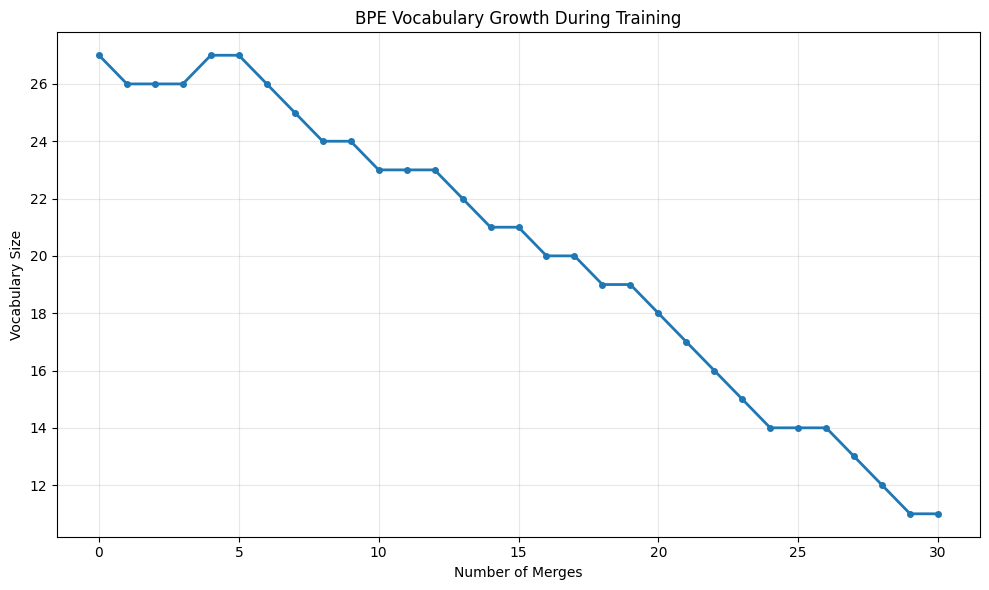


Starting vocabulary: 27 unique characters
After 30 merges: 11 tokens
Vocabulary grew by: -16 tokens


In [16]:
# Visualize vocabulary growth during training

def train_and_track_vocab_growth(text, max_merges=30):
    """
    Train BPE and track vocabulary size at each step.
    """
    # Start with characters
    tokens = []
    for word in text.split():
        tokens.extend(list(word) + ['</w>'])
    
    vocab_sizes = [len(set(tokens))]  # Initial vocab size
    
    merges = {}
    
    for i in range(max_merges):
        pairs = count_pairs(tokens)
        if not pairs:
            break
        
        best_pair = max(pairs, key=pairs.get)
        merged = best_pair[0] + best_pair[1]
        merges[best_pair] = merged
        
        tokens = merge_pair(tokens, best_pair)
        vocab_sizes.append(len(set(tokens)))
    
    return vocab_sizes


# Train and track
corpus = "the quick brown fox jumps over the lazy dog " * 10
vocab_sizes = train_and_track_vocab_growth(corpus, max_merges=30)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(vocab_sizes)), vocab_sizes, marker='o', linewidth=2, markersize=4)
plt.xlabel('Number of Merges')
plt.ylabel('Vocabulary Size')
plt.title('BPE Vocabulary Growth During Training')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nStarting vocabulary: {vocab_sizes[0]} unique characters")
print(f"After {len(vocab_sizes)-1} merges: {vocab_sizes[-1]} tokens")
print(f"Vocabulary grew by: {vocab_sizes[-1] - vocab_sizes[0]} tokens")

# Part 6: WordPiece (BERT's Method)

WordPiece is very similar to BPE, but with one key difference in how it chooses which pairs to merge.

## BPE vs WordPiece

**BPE (used by GPT):**
- Merge the **most frequent** pair
- Simple frequency counting

**WordPiece (used by BERT):**
- Merge the pair that **maximizes likelihood** of the training data
- Uses a scoring function based on probability

In practice, they produce very similar results!

## The ## Notation

WordPiece uses `##` to mark subword tokens that **continue** a word:

```python
"playing" → ["play", "##ing"]
"unhappiness" → ["un", "##hap", "##pi", "##ness"]
```

- `"play"` can start a word
- `"##ing"` can only continue a word

This helps the model know word boundaries!

## Example

In [17]:
# Simulate WordPiece tokenization (simplified)

def wordpiece_tokenize(word, vocab):
    """
    Simulate WordPiece tokenization.
    
    Args:
        word: Word to tokenize
        vocab: Set of valid tokens
        
    Returns:
        List of tokens with ## notation
    """
    tokens = []
    
    # Try to find longest matching prefix
    start = 0
    while start < len(word):
        end = len(word)
        found = False
        
        # Try progressively shorter substrings
        while start < end:
            substr = word[start:end]
            
            # Add ## if not at word start
            if start == 0:
                token = substr
            else:
                token = "##" + substr
            
            if token in vocab:
                tokens.append(token)
                start = end
                found = True
                break
            
            end -= 1
        
        if not found:
            # Unknown character
            tokens.append("[UNK]")
            start += 1
    
    return tokens


# Example vocabulary (simplified)
vocab = {
    # Word-starting tokens
    "play", "un", "happy", "like",
    # Continuation tokens (with ##)
    "##ing", "##ed", "##ness", "##ly",
    # Characters as fallback
    "p", "l", "a", "y", "i", "n", "g"
}

print("=" * 60)
print("WORDPIECE TOKENIZATION DEMO")
print("=" * 60)

test_words = ["playing", "played", "unhappiness", "likely"]

for word in test_words:
    tokens = wordpiece_tokenize(word, vocab)
    print(f"\n'{word}'")
    print(f"  → {tokens}")
    
    # Explain the tokens
    for token in tokens:
        if token.startswith("##"):
            print(f"     '{token}' = continuation")
        else:
            print(f"     '{token}' = word start")

WORDPIECE TOKENIZATION DEMO

'playing'
  → ['play', '##ing']
     'play' = word start
     '##ing' = continuation

'played'
  → ['play', '##ed']
     'play' = word start
     '##ed' = continuation

'unhappiness'
  → ['un', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '##ness']
     'un' = word start
     '[UNK]' = word start
     '[UNK]' = word start
     '[UNK]' = word start
     '[UNK]' = word start
     '[UNK]' = word start
     '##ness' = continuation

'likely'
  → ['like', '##ly']
     'like' = word start
     '##ly' = continuation


## Why the ## Notation?

It helps the model distinguish:

```python
"playing" → ["play", "##ing"]
"playoff" → ["play", "##off"]
```

Both start with "play", but:
- In "playing", "ing" is a suffix
- In "playoff", "off" is part of a compound word

The `##` marker helps the model learn these patterns!

## When to Use WordPiece vs BPE

In practice:
- **BPE**: Simpler, faster training, used by GPT models
- **WordPiece**: Slightly better for some languages, used by BERT

The difference is minor - both work great!

# Part 7: Special Tokens

Most tokenizers add **special tokens** that aren't part of the normal text. These serve important purposes!

## Common Special Tokens

| Token | Name | Purpose | Example |
|-------|------|---------|----------|
| `<BOS>` or `<s>` | Beginning of Sequence | Marks where text starts | T5, LLaMA |
| `<EOS>` or `</s>` | End of Sequence | Marks where text ends | T5, LLaMA |
| `<PAD>` | Padding | Fills sequences to same length | All models |
| `<UNK>` | Unknown | Represents unknown words | Word-level models |
| `[CLS]` | Classification | Special token for sentence embedding | BERT |
| `[SEP]` | Separator | Separates different sentences | BERT |
| `[MASK]` | Mask | Used for masked language modeling | BERT |
| `<\|endoftext\|>` | End of Text | GPT's special end marker | GPT-2, GPT-3 |

## Why Do We Need Them?

### 1. Mark Boundaries
```
Without markers: "Hello world" "How are you"
With markers:    "<BOS> Hello world <EOS> <BOS> How are you <EOS>"
```

### 2. Padding (for batching)
```
Sentence 1: ["Hello", "world", "<PAD>", "<PAD>"]
Sentence 2: ["How", "are", "you", "today"]
            ↑ Same length → Can batch together!
```

### 3. Task-specific markers
```
BERT classification:
[CLS] I love this movie [SEP]
  ↑
  This token's embedding = sentence meaning
```

## Examples by Model

In [18]:
# Demonstrate special tokens for different models

text = "Hello world"

print("=" * 60)
print("HOW DIFFERENT MODELS TOKENIZE THE SAME TEXT")
print("=" * 60)
print(f"\nOriginal text: '{text}'\n")

# GPT-2/GPT-3 style
print("GPT-2/GPT-3:")
gpt_tokens = ["<|endoftext|>", "Hello", "world", "<|endoftext|>"]
print(f"  {gpt_tokens}")
print("  - <|endoftext|> marks document boundaries")
print("  - Used for both start and end")

# BERT style
print("\nBERT:")
bert_tokens = ["[CLS]", "Hello", "world", "[SEP]"]
print(f"  {bert_tokens}")
print("  - [CLS] token's embedding = sentence representation")
print("  - [SEP] marks end of sequence")

# T5 style
print("\nT5:")
t5_tokens = ["Hello", "world", "</s>"]
print(f"  {t5_tokens}")
print("  - </s> marks end of sequence")
print("  - No special start token")

# LLaMA style
print("\nLLaMA:")
llama_tokens = ["<s>", "Hello", "world", "</s>"]
print(f"  {llama_tokens}")
print("  - <s> marks start")
print("  - </s> marks end")

HOW DIFFERENT MODELS TOKENIZE THE SAME TEXT

Original text: 'Hello world'

GPT-2/GPT-3:
  ['<|endoftext|>', 'Hello', 'world', '<|endoftext|>']
  - <|endoftext|> marks document boundaries
  - Used for both start and end

BERT:
  ['[CLS]', 'Hello', 'world', '[SEP]']
  - [CLS] token's embedding = sentence representation
  - [SEP] marks end of sequence

T5:
  ['Hello', 'world', '</s>']
  - </s> marks end of sequence
  - No special start token

LLaMA:
  ['<s>', 'Hello', 'world', '</s>']
  - <s> marks start
  - </s> marks end


In [19]:
# Demonstrate padding

sentences = [
    ["Hello"],
    ["How", "are", "you"],
    ["This", "is", "a", "longer", "sentence"]
]

# Find max length
max_len = max(len(s) for s in sentences)

print("=" * 60)
print("PADDING DEMONSTRATION")
print("=" * 60)
print(f"\nMax length: {max_len}\n")

# Pad all sentences
print("Before padding (different lengths):")
for i, sent in enumerate(sentences):
    print(f"  Sentence {i+1}: {sent} (length {len(sent)})")

print("\nAfter padding (all same length):")
padded = []
for i, sent in enumerate(sentences):
    # Add <PAD> tokens to reach max length
    padding_needed = max_len - len(sent)
    padded_sent = sent + ["<PAD>"] * padding_needed
    padded.append(padded_sent)
    print(f"  Sentence {i+1}: {padded_sent}")

print("\n✅ Now all sentences have the same length!")
print("   This allows efficient batching in neural networks.")

PADDING DEMONSTRATION

Max length: 5

Before padding (different lengths):
  Sentence 1: ['Hello'] (length 1)
  Sentence 2: ['How', 'are', 'you'] (length 3)
  Sentence 3: ['This', 'is', 'a', 'longer', 'sentence'] (length 5)

After padding (all same length):
  Sentence 1: ['Hello', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
  Sentence 2: ['How', 'are', 'you', '<PAD>', '<PAD>']
  Sentence 3: ['This', 'is', 'a', 'longer', 'sentence']

✅ Now all sentences have the same length!
   This allows efficient batching in neural networks.


In [20]:
# Demonstrate BERT's [MASK] token for training

print("=" * 60)
print("BERT'S MASKED LANGUAGE MODELING")
print("=" * 60)

original = ["I", "love", "eating", "pizza"]
masked = ["I", "love", "[MASK]", "pizza"]

print("\nOriginal sentence:")
print(f"  {' '.join(original)}")

print("\nDuring BERT training:")
print(f"  Input:  {' '.join(masked)}")
print(f"  Task:   Predict what [MASK] should be")
print(f"  Answer: 'eating'")

print("\nThis is how BERT learns language understanding!")
print("15% of tokens are randomly masked during training.")

BERT'S MASKED LANGUAGE MODELING

Original sentence:
  I love eating pizza

During BERT training:
  Input:  I love [MASK] pizza
  Task:   Predict what [MASK] should be
  Answer: 'eating'

This is how BERT learns language understanding!
15% of tokens are randomly masked during training.


## Implementing a Tokenizer with Special Tokens

In [21]:
class TokenizerWithSpecialTokens:
    """
    Simple tokenizer that includes special tokens.
    """
    
    def __init__(self, style="gpt"):
        """
        Args:
            style: "gpt", "bert", "t5", or "llama"
        """
        self.style = style
        
        # Define special tokens for each style
        if style == "gpt":
            self.bos_token = "<|endoftext|>"
            self.eos_token = "<|endoftext|>"
            self.pad_token = "<|pad|>"
        elif style == "bert":
            self.bos_token = "[CLS]"
            self.eos_token = "[SEP]"
            self.pad_token = "[PAD]"
        elif style == "t5":
            self.bos_token = None
            self.eos_token = "</s>"
            self.pad_token = "<pad>"
        elif style == "llama":
            self.bos_token = "<s>"
            self.eos_token = "</s>"
            self.pad_token = "<pad>"
    
    def encode(self, text, add_special_tokens=True):
        """
        Encode text with special tokens.
        
        Args:
            text: Text to encode
            add_special_tokens: Whether to add BOS/EOS tokens
        """
        # Simple word tokenization
        tokens = text.split()
        
        if add_special_tokens:
            if self.bos_token:
                tokens = [self.bos_token] + tokens
            if self.eos_token:
                tokens = tokens + [self.eos_token]
        
        return tokens
    
    def pad(self, tokens_list, max_length=None):
        """
        Pad a list of token sequences to the same length.
        
        Args:
            tokens_list: List of token lists
            max_length: Maximum length (uses longest if None)
        """
        if max_length is None:
            max_length = max(len(tokens) for tokens in tokens_list)
        
        padded = []
        for tokens in tokens_list:
            padding_needed = max_length - len(tokens)
            padded_tokens = tokens + [self.pad_token] * padding_needed
            padded.append(padded_tokens)
        
        return padded


# Test different styles
text = "Hello world"

for style in ["gpt", "bert", "t5", "llama"]:
    tokenizer = TokenizerWithSpecialTokens(style=style)
    tokens = tokenizer.encode(text)
    print(f"{style.upper():6s}: {tokens}")

GPT   : ['<|endoftext|>', 'Hello', 'world', '<|endoftext|>']
BERT  : ['[CLS]', 'Hello', 'world', '[SEP]']
T5    : ['Hello', 'world', '</s>']
LLAMA : ['<s>', 'Hello', 'world', '</s>']


# Part 8: Vocabulary Size Trade-offs

One of the most important decisions when building a tokenizer: **How big should the vocabulary be?**

## The Trade-off

**Small vocabulary (e.g., 1,000 tokens):**
- ✅ Fewer parameters in embedding layer
- ✅ Less memory usage
- ❌ Longer sequences (more splits)
- ❌ More computation (transformer is O(n²))

**Large vocabulary (e.g., 100,000 tokens):**
- ✅ Shorter sequences (fewer splits)
- ✅ Less computation in transformer
- ❌ More parameters in embedding layer
- ❌ More memory usage

## Real Model Vocabulary Sizes

| Model | Vocabulary Size | Languages | Reasoning |
|-------|----------------|-----------|----------|
| GPT-2 | 50,257 | Mostly English | Good balance for English |
| GPT-4 | ~100,000 | Multilingual | Better for non-English |
| BERT | 30,522 | English | English-focused |
| LLaMA | 32,000 | Multilingual | Efficient and effective |
| T5 | 32,000 | Multilingual | Same as LLaMA |

Most models converge on **30,000-50,000** as the sweet spot!

## The Math

Let's calculate the impact:

**Embedding layer size:**
```
Parameters = vocab_size × embedding_dim

Small vocab (10,000 × 1024):  10M parameters
Medium vocab (50,000 × 1024): 51M parameters
Large vocab (100,000 × 1024): 102M parameters
```

**Transformer computation:**
```
Attention complexity = O(sequence_length²)

If small vocab → 2x longer sequences → 4x more computation!
```

Let's experiment:

In [22]:
# Simulate vocabulary size impact on sequence length

def estimate_sequence_length(text, vocab_size):
    """
    Rough estimate of sequence length for different vocab sizes.
    
    Smaller vocab → more splits → longer sequences
    """
    # This is a simplification, but gives the right intuition
    char_count = len(text)
    
    if vocab_size <= 1000:
        # Small vocab: lots of character-level splits
        avg_token_length = 2
    elif vocab_size <= 10000:
        avg_token_length = 3
    elif vocab_size <= 50000:
        avg_token_length = 4
    else:
        # Large vocab: more whole words
        avg_token_length = 5
    
    return char_count // avg_token_length


sample_text = "The transformer architecture revolutionized natural language processing"

vocab_sizes = [1_000, 10_000, 50_000, 100_000]
sequence_lengths = [estimate_sequence_length(sample_text, vs) for vs in vocab_sizes]

print("=" * 60)
print("VOCABULARY SIZE vs SEQUENCE LENGTH")
print("=" * 60)
print(f"\nText: '{sample_text}'")
print(f"Characters: {len(sample_text)}\n")

for vs, sl in zip(vocab_sizes, sequence_lengths):
    print(f"Vocab size {vs:7,d}: ~{sl:2d} tokens")

VOCABULARY SIZE vs SEQUENCE LENGTH

Text: 'The transformer architecture revolutionized natural language processing'
Characters: 71

Vocab size   1,000: ~35 tokens
Vocab size  10,000: ~23 tokens
Vocab size  50,000: ~17 tokens
Vocab size 100,000: ~14 tokens


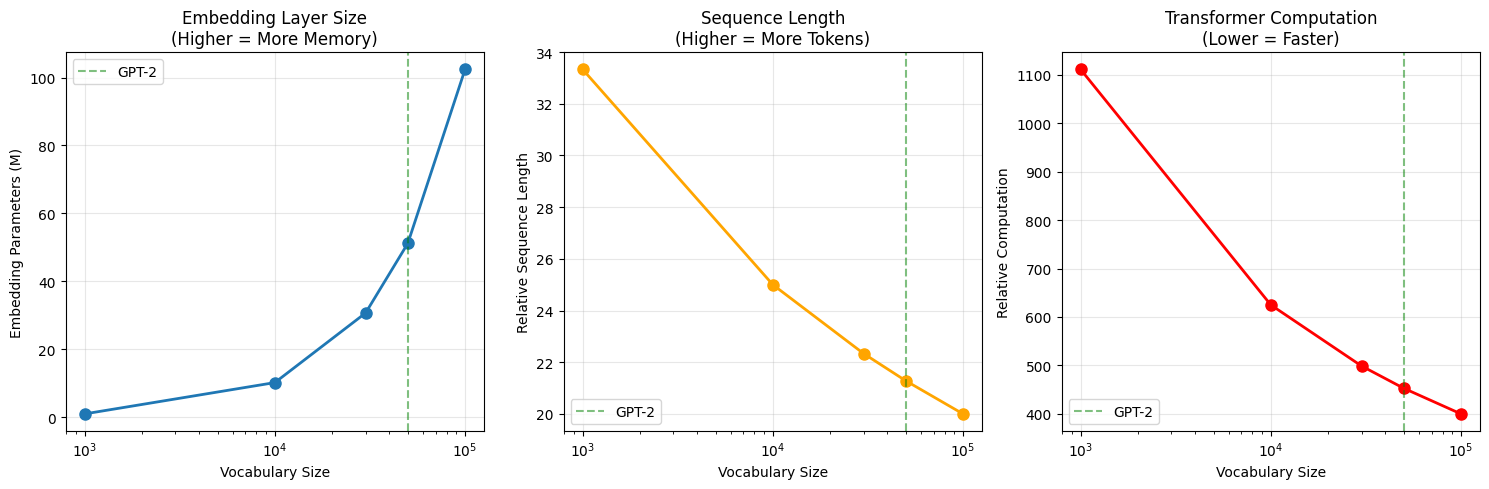


✅ The sweet spot is around 30,000-50,000 tokens
   - Not too much memory for embeddings
   - Not too long sequences
   - Reasonable computation cost


In [23]:
# Visualize the trade-offs

vocab_sizes = np.array([1_000, 10_000, 30_000, 50_000, 100_000])
embedding_dim = 1024

# Calculate metrics
embedding_params = vocab_sizes * embedding_dim / 1_000_000  # In millions
relative_seq_length = 100 / np.log10(vocab_sizes)  # Rough inverse relationship
relative_computation = relative_seq_length ** 2  # O(n²) attention

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Embedding parameters
axes[0].plot(vocab_sizes, embedding_params, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Vocabulary Size')
axes[0].set_ylabel('Embedding Parameters (M)')
axes[0].set_title('Embedding Layer Size\n(Higher = More Memory)')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(50_000, color='green', linestyle='--', alpha=0.5, label='GPT-2')
axes[0].legend()

# Sequence length
axes[1].plot(vocab_sizes, relative_seq_length, marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Vocabulary Size')
axes[1].set_ylabel('Relative Sequence Length')
axes[1].set_title('Sequence Length\n(Higher = More Tokens)')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(50_000, color='green', linestyle='--', alpha=0.5, label='GPT-2')
axes[1].legend()

# Computation
axes[2].plot(vocab_sizes, relative_computation, marker='o', linewidth=2, markersize=8, color='red')
axes[2].set_xlabel('Vocabulary Size')
axes[2].set_ylabel('Relative Computation')
axes[2].set_title('Transformer Computation\n(Lower = Faster)')
axes[2].set_xscale('log')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(50_000, color='green', linestyle='--', alpha=0.5, label='GPT-2')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n✅ The sweet spot is around 30,000-50,000 tokens")
print("   - Not too much memory for embeddings")
print("   - Not too long sequences")
print("   - Reasonable computation cost")

## Why GPT-4 Uses ~100,000

GPT-4 has a larger vocabulary than GPT-2 because:

1. **Multilingual**: Needs tokens for many languages
2. **Better efficiency**: Shorter sequences worth the memory cost
3. **Model size**: GPT-4 is huge anyway, embedding size is small fraction
4. **Token healing**: Better handling of word boundaries

## The Final Verdict

For most use cases:
- **English-only**: 30,000-50,000 tokens
- **Multilingual**: 50,000-100,000 tokens
- **Research/experimentation**: 32,000 (common choice)

# Part 9: Putting It All Together

Let's build a **complete tokenization pipeline** that combines everything we've learned!

## The Full Pipeline

```
Raw Text
    ↓
1. Normalization (lowercase, unicode, etc.)
    ↓
2. Pre-tokenization (split on whitespace/punctuation)
    ↓
3. Subword Tokenization (BPE/WordPiece)
    ↓
4. Add Special Tokens (BOS/EOS/PAD)
    ↓
5. Convert to IDs
    ↓
Ready for Model!
```

In [24]:
class CompleteTokenizer:
    """
    Complete tokenization pipeline.
    
    Combines all the pieces we've learned:
    - Normalization
    - BPE tokenization
    - Special tokens
    - ID conversion
    """
    
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.merges = {}
        self.vocab = {}
        self.inverse_vocab = {}
        
        # Special tokens
        self.pad_token = "<PAD>"
        self.bos_token = "<BOS>"
        self.eos_token = "<EOS>"
        self.unk_token = "<UNK>"
        
    def normalize(self, text):
        """
        Step 1: Normalize text.
        """
        # Lowercase
        text = text.lower()
        # Could add more: remove accents, handle unicode, etc.
        return text
    
    def pre_tokenize(self, text):
        """
        Step 2: Split into words.
        """
        # Split on whitespace and punctuation
        words = re.findall(r'\w+|[^\w\s]', text)
        return words
    
    def train(self, text):
        """
        Train the tokenizer on text.
        """
        print("Training tokenizer...\n")
        
        # Step 1: Normalize
        text = self.normalize(text)
        print(f"1. Normalized: '{text[:50]}...'")
        
        # Step 2: Pre-tokenize
        words = self.pre_tokenize(text)
        print(f"2. Pre-tokenized: {words[:10]}...")
        
        # Step 3: Build character-level tokens with word boundaries
        tokens = []
        for word in words:
            tokens.extend(list(word) + ['</w>'])
        print(f"3. Character tokens: {tokens[:20]}...")
        
        # Step 4: Train BPE
        print("\n4. Training BPE...")
        num_merges = self.vocab_size - 100  # Reserve space for special tokens
        
        for i in range(num_merges):
            pairs = count_pairs(tokens)
            if not pairs:
                break
            
            best_pair = max(pairs, key=pairs.get)
            merged = best_pair[0] + best_pair[1]
            self.merges[best_pair] = merged
            tokens = merge_pair(tokens, best_pair)
            
            if i < 5:  # Print first few merges
                print(f"   Merge {i+1}: {best_pair} → '{merged}'")
        
        print(f"   ... ({len(self.merges)} total merges)")
        
        # Step 5: Build vocabulary
        print("\n5. Building vocabulary...")
        
        # Add special tokens first
        special_tokens = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        for i, token in enumerate(special_tokens):
            self.vocab[token] = i
            self.inverse_vocab[i] = token
        
        # Add learned tokens
        next_id = len(special_tokens)
        for token in sorted(set(tokens)):
            if token not in self.vocab:
                self.vocab[token] = next_id
                self.inverse_vocab[next_id] = token
                next_id += 1
        
        print(f"   Vocabulary size: {len(self.vocab)}")
        print(f"   Special tokens: {special_tokens}")
        
    def encode(self, text, add_special_tokens=True):
        """
        Encode text to token IDs.
        
        Returns both tokens (strings) and IDs (integers).
        """
        # Normalize and pre-tokenize
        text = self.normalize(text)
        words = self.pre_tokenize(text)
        
        # Character-level with word boundaries
        tokens = []
        for word in words:
            tokens.extend(list(word) + ['</w>'])
        
        # Apply BPE merges
        for pair, merged in self.merges.items():
            tokens = merge_pair(tokens, pair)
        
        # Add special tokens
        if add_special_tokens:
            tokens = [self.bos_token] + tokens + [self.eos_token]
        
        # Convert to IDs
        ids = []
        for token in tokens:
            if token in self.vocab:
                ids.append(self.vocab[token])
            else:
                ids.append(self.vocab[self.unk_token])
        
        return tokens, ids
    
    def decode(self, ids):
        """
        Decode token IDs back to text.
        """
        # Convert IDs to tokens
        tokens = [self.inverse_vocab.get(id, self.unk_token) for id in ids]
        
        # Remove special tokens
        tokens = [t for t in tokens if t not in [self.pad_token, self.bos_token, self.eos_token]]
        
        # Join and clean up
        text = ''.join(tokens)
        text = text.replace('</w>', ' ')
        
        return text.strip()


# Train it!
corpus = """
The quick brown fox jumps over the lazy dog.
Natural language processing is fascinating.
Transformers revolutionized the field.
Tokenization is the first step.
""" * 5  # Repeat for better BPE training

tokenizer = CompleteTokenizer(vocab_size=150)
tokenizer.train(corpus)

Training tokenizer...

1. Normalized: '
the quick brown fox jumps over the lazy dog.
natu...'
2. Pre-tokenized: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']...
3. Character tokens: ['t', 'h', 'e', '</w>', 'q', 'u', 'i', 'c', 'k', '</w>', 'b', 'r', 'o', 'w', 'n', '</w>', 'f', 'o', 'x', '</w>']...

4. Training BPE...
   Merge 1: ('</w>', 't') → '</w>t'
   Merge 2: ('e', '</w>') → 'e</w>'
   Merge 3: ('h', 'e</w>') → 'he</w>'
   Merge 4: ('</w>', '.') → '</w>.'
   Merge 5: ('</w>t', 'he</w>') → '</w>the</w>'
   ... (50 total merges)

5. Building vocabulary...
   Vocabulary size: 45
   Special tokens: ['<PAD>', '<BOS>', '<EOS>', '<UNK>']


In [25]:
# Test the complete pipeline

test_texts = [
    "The quick fox",
    "Natural language processing",
    "Transformers are amazing"
]

print("\n" + "=" * 60)
print("COMPLETE TOKENIZATION PIPELINE")
print("=" * 60)

for text in test_texts:
    tokens, ids = tokenizer.encode(text)
    decoded = tokenizer.decode(ids)
    
    print(f"\nOriginal:  '{text}'")
    print(f"Tokens:    {tokens}")
    print(f"IDs:       {ids}")
    print(f"Decoded:   '{decoded}'")
    print(f"Match:     {'✅' if decoded.lower() == text.lower() else '❌'}")


COMPLETE TOKENIZATION PIPELINE

Original:  'The quick fox'
Tokens:    ['<BOS>', 't', 'he</w>', 'quick</w>', 'fo', 'x', '</w>', '<EOS>']
IDs:       [1, 42, 20, 3, 18, 3, 4, 2]
Decoded:   'the <UNK>fo<UNK>'
Match:     ❌

Original:  'Natural language processing'
Tokens:    ['<BOS>', 'nat', 'u', 'ra', 'l', '</w>', 'la', 'ng', 'u', 'a', 'g', 'e</w>', 'p', 'ro', 'c', 'e', 's', 's', 'ing', '</w>', '<EOS>']
IDs:       [1, 30, 43, 37, 25, 4, 26, 31, 43, 10, 19, 15, 34, 38, 12, 14, 39, 39, 22, 4, 2]
Decoded:   'natural language processing'
Match:     ✅

Original:  'Transformers are amazing'
Tokens:    ['<BOS>', 't', 'ra', 'n', 's', 'fo', 'r', 'm', 'er', 's</w>', 'a', 'r', 'e</w>', 'a', 'm', 'a', 'z', 'ing', '</w>', '<EOS>']
IDs:       [1, 42, 37, 28, 39, 18, 36, 27, 16, 40, 10, 36, 15, 10, 27, 10, 3, 22, 4, 2]
Decoded:   'transformers are ama<UNK>ing'
Match:     ❌


In [26]:
# Demonstrate padding for batching

sentences = [
    "Hello",
    "How are you",
    "Transformers are great"
]

print("\n" + "=" * 60)
print("BATCHING WITH PADDING")
print("=" * 60)

# Encode all sentences
all_tokens = []
all_ids = []

for sent in sentences:
    tokens, ids = tokenizer.encode(sent)
    all_tokens.append(tokens)
    all_ids.append(ids)

# Find max length
max_len = max(len(ids) for ids in all_ids)

print(f"\nMax sequence length: {max_len}\n")

# Pad all sequences
pad_id = tokenizer.vocab[tokenizer.pad_token]

print("Padded sequences:")
for i, (sent, ids) in enumerate(zip(sentences, all_ids)):
    padding_needed = max_len - len(ids)
    padded_ids = ids + [pad_id] * padding_needed
    
    print(f"\n{i+1}. '{sent}'")
    print(f"   IDs: {padded_ids}")
    print(f"   Length: {len(padded_ids)} (padded: {padding_needed})")

print("\n✅ All sequences now have the same length!")
print("   Ready to be batched and fed to the model.")


BATCHING WITH PADDING

Max sequence length: 19

Padded sequences:

1. 'Hello'
   IDs: [1, 3, 14, 25, 25, 33, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Length: 19 (padded: 11)

2. 'How are you'
   IDs: [1, 3, 33, 3, 4, 10, 36, 15, 3, 33, 43, 4, 2, 0, 0, 0, 0, 0, 0]
   Length: 19 (padded: 6)

3. 'Transformers are great'
   IDs: [1, 42, 37, 28, 39, 18, 36, 27, 16, 40, 10, 36, 15, 19, 36, 14, 11, 4, 2]
   Length: 19 (padded: 0)

✅ All sequences now have the same length!
   Ready to be batched and fed to the model.


# Exercises

Now it's your turn! Try these exercises to solidify your understanding.

## Exercise 1: Character Tokenizer

Build a character tokenizer and test it on different texts. Compare sequence lengths.

In [27]:
# Exercise 1: Build and test a character tokenizer

# TODO:
# 1. Create a CharacterTokenizer instance
# 2. Build vocabulary from sample text
# 3. Encode and decode "Transformers"
# 4. Compare length to word-level tokenization

# Your code here:


## Exercise 2: BPE from Scratch

Implement BPE training and encoding on your own text.

In [28]:
# Exercise 2: Train BPE on custom text

# TODO:
# 1. Choose your own training text (a paragraph you like)
# 2. Train a BPETokenizer with 15 merges
# 3. Print the merge rules
# 4. Encode a sentence from your text
# 5. Encode a sentence NOT in your training text

# Your code here:


## Exercise 3: Special Token Explorer

Add BOS/EOS tokens to sequences and visualize them.

In [29]:
# Exercise 3: Work with special tokens

# TODO:
# 1. Create a TokenizerWithSpecialTokens for each style (gpt, bert, t5, llama)
# 2. Encode "Hello world" with each
# 3. Print side-by-side comparison
# 4. Pad a batch of 3 sentences with different lengths

# Your code here:


## Exercise 4: Vocabulary Size Experiment

Explore how vocabulary size affects sequence length.

In [30]:
# Exercise 4: Vocabulary size impact

# TODO:
# 1. Pick a paragraph of text
# 2. Train BPE tokenizers with different num_merges: [5, 10, 20, 50]
# 3. Encode the same sentence with each tokenizer
# 4. Plot sequence length vs num_merges
# 5. What's the relationship?

# Your code here:


## Exercise 5: Challenge - Simple WordPiece

Implement a basic WordPiece tokenizer with the ## notation.

In [31]:
# Exercise 5: Implement WordPiece (challenge!)

# TODO:
# 1. Create a vocabulary with word-starting and continuation tokens
#    Example: {"play", "##ing", "##ed", "un", "##happy"}
# 2. Implement a function that tokenizes a word using greedy longest-match
# 3. Add ## to continuation tokens
# 4. Test on: "playing", "unhappy", "replay"

# Hint: Start from the beginning of the word and find the longest match

# Your code here:


# Summary

Congratulations! You now understand how text becomes numbers in modern language models.

## Key Takeaways

### 1. Three Approaches to Tokenization

| Method | Vocab Size | Pros | Cons |
|--------|-----------|------|------|
| **Character** | ~256 | Simple, no OOV | Very long sequences |
| **Word** | 100k+ | Meaningful units | OOV problem, huge vocab |
| **Subword** | ~50k | **Best balance** | More complex |

### 2. Byte-Pair Encoding (BPE)

The algorithm used by GPT:
1. Start with characters
2. Count adjacent pairs
3. Merge most frequent pair
4. Repeat

Result: Efficient subword tokenization!

### 3. Special Tokens

- `<BOS>` / `<EOS>`: Mark boundaries
- `<PAD>`: Enable batching
- `<UNK>`: Handle unknowns
- Model-specific: `[CLS]`, `[SEP]`, `[MASK]`

### 4. Vocabulary Size Trade-off

- **Small vocab**: Less memory, longer sequences, more computation
- **Large vocab**: More memory, shorter sequences, less computation
- **Sweet spot**: 30,000-50,000 tokens

### 5. The Complete Pipeline

```
Text → Normalization → Pre-tokenization → BPE → Special Tokens → IDs → Model
```

## Why Tokenization Matters

Good tokenization is crucial for model performance:
- **Efficiency**: Shorter sequences = faster training and inference
- **Generalization**: Subwords help with rare words and morphology
- **Multilingual**: Can handle multiple languages efficiently
- **Robustness**: Handles typos and new words gracefully

## Comparison Table

| Model | Tokenizer | Vocab Size | Special Tokens |
|-------|-----------|-----------|----------------|
| GPT-2 | BPE | 50,257 | `<\|endoftext\|>` |
| GPT-4 | BPE | ~100,000 | `<\|endoftext\|>` |
| BERT | WordPiece | 30,522 | `[CLS]`, `[SEP]`, `[MASK]` |
| T5 | SentencePiece | 32,000 | `</s>` |
| LLaMA | BPE | 32,000 | `<s>`, `</s>` |

## What's Next?

In **Notebook 06**, we'll finally put everything together:

1. **Tokenize** text (this notebook)
2. **Embed** tokens (notebook 03)
3. **Process** with Transformer (notebook 04)
4. **Train** the model (notebook 06)
5. **Generate** text (notebook 06)

You now have all the pieces. Time to build a complete language model!

## Further Reading

Want to dive deeper?

- **BPE Paper**: "Neural Machine Translation of Rare Words with Subword Units"
- **WordPiece**: Original BERT paper
- **SentencePiece**: Google's language-agnostic tokenizer
- **tiktoken**: OpenAI's BPE implementation (in Rust, very fast!)
- **Hugging Face Tokenizers**: Production-ready implementations

## Practice Ideas

1. Train BPE on different languages - how does it adapt?
2. Compare tokenization of code vs natural language
3. Experiment with vocabulary sizes on your own dataset
4. Implement SentencePiece (works on raw bytes!)
5. Try tiktoken with GPT-4's tokenizer on multilingual text

Great work! See you in the next notebook where we train a complete model! 🚀